In [1]:
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)
from keras.applications.vgg19 import VGG19 as VGG16
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

c:\users\eros\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\eros\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\eros\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\eros\appdata\

1.14.0


Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
keras.backend.set_session(session)

imagepaths = []
categories_set = set()

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk("Folds_Dataset_Final", topdown=False): 
    for name in files:
        path = os.path.join(root, name)
        if name.startswith('c'):
            continue
        if path.endswith("PNG"): # We want only the images
            imagepaths.append(path)
            categories_set.add(os.path.split(root)[1])

categories_list = list(sorted(categories_set))

categories = dict(zip(categories_list, range(len(categories_list))))
print(categories)

{'1': 0, '2': 1, '4': 2, '5': 3, '7': 4, '9': 5, 'A': 6, 'Adulto': 7, 'America': 8, 'Aviao': 9, 'B': 10, 'C': 11, 'Casa': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'Gasolina': 17, 'I': 18, 'Identidade': 19, 'Junto': 20, 'L': 21, 'Lei': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'Palavra': 27, 'Pedra': 28, 'Pequeno': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'Verbo': 36, 'W': 37, 'X': 38, 'Y': 39}


In [3]:
print(len(imagepaths)) # If > 0, then a PNG image was loaded
size = 50, 50
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
    img = cv2.imread(path) # Reads image and returns np.array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
    img = cv2.resize(img, size) # Reduce image size so training can be faster
    X.append(img)

    # Processing label in image path
    category = os.path.split(os.path.split(path)[0])[1]
    label = categories[category]
    y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), *size, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

4800
Images loaded:  4800
Labels loaded:  4800


In [6]:
print(y[0], imagepaths[0]) # Debugging

ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)


from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Sequential, Model, load_model

img_height,img_width = size
num_classes = len(categories)
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(img_height, img_width, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(categories), activation='softmax'))

model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
          loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
          metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.
# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2, validation_data=(X_test, y_test), callbacks=[mcp_save,])

test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test accuracy: {test_acc*100:2.2f}%')

predictions = model.predict(X_test) # Make predictions towards the test set

0 Folds_Dataset_Final\Fold1\1\0.PNG
Train on 3360 samples, validate on 1440 samples
Epoch 1/100
 - 1s - loss: 3.6934 - accuracy: 0.0964 - val_loss: 2.4552 - val_accuracy: 0.2674
Epoch 2/100
 - 0s - loss: 1.6930 - accuracy: 0.4905 - val_loss: 0.8767 - val_accuracy: 0.7944
Epoch 3/100
 - 0s - loss: 0.6686 - accuracy: 0.7982 - val_loss: 0.3281 - val_accuracy: 0.9222
Epoch 4/100
 - 0s - loss: 0.3397 - accuracy: 0.8979 - val_loss: 0.1714 - val_accuracy: 0.9569
Epoch 5/100
 - 0s - loss: 0.2153 - accuracy: 0.9342 - val_loss: 0.1059 - val_accuracy: 0.9708
Epoch 6/100
 - 0s - loss: 0.1281 - accuracy: 0.9589 - val_loss: 0.1246 - val_accuracy: 0.9701
Epoch 7/100
 - 0s - loss: 0.1013 - accuracy: 0.9670 - val_loss: 0.0993 - val_accuracy: 0.9785
Epoch 8/100
 - 0s - loss: 0.0902 - accuracy: 0.9699 - val_loss: 0.0877 - val_accuracy: 0.9806
Epoch 9/100
 - 0s - loss: 0.0661 - accuracy: 0.9810 - val_loss: 0.0654 - val_accuracy: 0.9806
Epoch 10/100
 - 0s - loss: 0.0559 - accuracy: 0.9824 - val_loss: 0.127

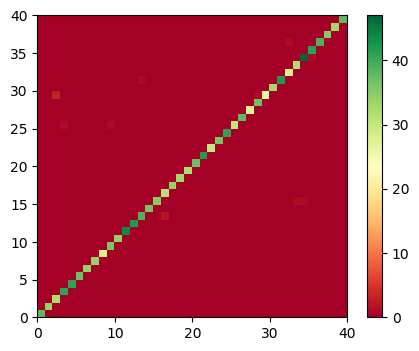

In [7]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

df = pd.DataFrame(confusion_matrix(y_test, y_pred), 
         columns=[f"Predicted {x}" for x in categories_list ],
         index=[f"Actual {x}" for x in categories_list ])


fig, axis = plt.subplots(figsize=(5, 4), dpi= 100)
heatmap = axis.pcolor(df.values, cmap=plt.cm.RdYlGn)
plt.colorbar(heatmap)

In [8]:
fig.savefig('heatmap_lasic_lenet_dropout')

df.to_csv('lasic_results_lenet_dropout.csv')

model.save('Lasic_lenet_dropout.h5')

In [9]:
session.close()